# Машинное обучение, DS-поток
## Задание 1.12


**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds21_bot`.
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.
* За задание можно получить до **20 баллов**:
  * часть 1 &mdash; 5 баллов, 
  * часть 2 &mdash; 15 баллов.


In [ ]:
!pip install torch==1.5.0
!pip install torchvision==0.6.0

     |████████████████████████████████| 752.0 MB 9.8 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.5.0 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.5.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.5.0 which is incompatible.
     |████████████████████████████████| 6.6 MB 4.5 MB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113


In [ ]:
!pip install pycocotools

In [1]:
import numpy as np
from random import choice
import matplotlib.pyplot as plt
import json
from collections import Counter
from pathlib import Path
from tqdm import tqdm_notebook as tqdm

%env CUDA_VISIBLE_DEVICES=0
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models
from torchvision.datasets import coco
from torchvision import transforms

from sklearn.model_selection import train_test_split

from nltk.tokenize import TweetTokenizer

env: CUDA_VISIBLE_DEVICES=0


In [ ]:
print(torch.__version__)

1.5.0


# Image Captioning

### План работы.
**Часть 1.** В качестве энкодера, переводящего изображения в векторы, взять предобученную сеть inception v3. Эту часть можно пропустить с потерей баллов, взяв готовые векторы, ссылка на которые есть во второй части.

**Часть 2.** В качестве декодера, переводящего векторы в текст описания, взять LSTM; обучить декодер на векторизованных изображениях датасета [MSCOCO](http://cocodataset.org/#download).

Задача image captioning заключается в генерации текстовых описаний к изображениям. В большинстве случаев используются архитектуры из двух частей &mdash; энкодера, переводящего изображения в векторы, и декодера, генерирующего текст по этим векторам. Поскольку обучать энкодер и декодер вместе &mdash; вычислительно затратная операция, мы решили разделить их и разбить домашнее задание на две части.

## Часть 1. Векторизация изображений

![](https://docs.google.com/uc?export=download&id=18Dp1dng87NbnhlBHnFVoEaiKlNZEXybh)


В этой части вам предстоит выполнить первый этап задачи image captioning &mdash; обучения энкодера для перевода изображений в векторы. 

**Замечание.** Выполнение этого задания требует больших вычислительных ресурсов. Рекомендуется использовать Google Colab или ноутбук с GPU. Кроме того, вы можете пропустить эту часть с потерей баллов и начать сразу с генерации текстов по векторам.

### Данные

Для решения задачи используется датасет COCO (Common Objects in Context), содержащий большое количество изображений для image captioning.

Загрузим данные. Понадобится около 18 гигабайт на диске.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Загрузим данные с http://cocodataset.org/#download
'''
!curl http://images.cocodataset.org/zips/train2017.zip > train2017.zip
!curl http://images.cocodataset.org/zips/val2017.zip > val2017.zip
!curl http://images.cocodataset.org/annotations/annotations_trainval2017.zip > annotations_trainval2017.zip

!unzip annotations_trainval2017.zip
!unzip train2017.zip > log
!unzip val2017.zip > log
'''
!unzip '/content/drive/MyDrive/Colab_Notebooks/DS/ML/12/annotations_trainval2017.zip'
!unzip '/content/drive/MyDrive/Colab_Notebooks/DS/ML/12/train2017.zip' > log
!unzip '/content/drive/MyDrive/Colab_Notebooks/DS/ML/12/val2017.zip' > log

Archive:  /content/drive/MyDrive/Colab_Notebooks/DS/ML/12/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [ ]:
! rm ./log

In [ ]:
#!unzip '/content/drive/MyDrive/Colab_Notebooks/DS/ML/12/train2017.zip' > log

Чтобы упростить вам задачу, мы не будем обучать энкодер, а возьмём предобученные веса для сети. Предлагается  использовать сеть `ResNet`, но вы можете выбрать любую сеть для изображений на свой вкус.

Важно помнить, что перед передачей в сеть изображения нужно предобработать. При этом, у каждой сети свои требования к размеру входному изображению и способу нормирования каналов. 

In [ ]:
# предобработка для Inception-v3
preprocess = transforms.Compose((
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
))

Инициализируем `DataLoader` для генерации батчей. Значение `batch_size` выберите в зависимости от имеющихся вычислительных ресурсов.

In [ ]:
coco_train = coco.CocoCaptions(
    "./train2017/", "./annotations/captions_train2017.json", transform=preprocess
)

data_loader = torch.utils.data.DataLoader(
    dataset=coco_train, 
    batch_size=128, 
    shuffle=False, 
    num_workers=4
)

Модифицируем предобученную сеть для генерации векторов по изображениям. Как было сказано выше, вы можете выбрать любую архитектуру, но размер выхода должен быть равным 2048. 

В `torchvision.models` содержатся сети, предобученные на задаче классификации. Поэтому для их использования надо удалить из них последний слой.

In [27]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        # загрузим предобученную сеть
        net = models.resnet50(pretrained=True)

        for param in net.parameters():
            # отключим подсчёт градиента для параметра
            param.requires_grad_(False)
        
        # выберем все слои, кроме последнего. Воспользуйтесь методом children() 
        # у класса предобученной сети
        modules = list(net.children())[:-1]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        return features

In [ ]:
model = EncoderCNN()
# установим режим evaluation. Это отключит все dropout-ы в сети
model = nn.DataParallel(model.train(False).cuda())

### Векторизация изображений

Получим векторы представления изображений с помощью модели.

**Замечание.** Требует большого объёма RAM. Если памяти не хватает, то следует каждые $K$ итераций сохранять векторы на диск и очищать память.


In [ ]:
vectors, captions = [], []

for img_batch, capt_batch in tqdm(data_loader):
    capt_batch = list(zip(*capt_batch))
    img_batch = Variable(img_batch, volatile=True)
    # получите векторы изображений из модели
    vec_batch = model(img_batch).cpu().numpy()
    
    captions.extend(capt_batch)
    vectors.extend([vec for vec in vec_batch])
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/925 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


Переведите тексты описаний в нижний регистр и токенизируйте их.

In [ ]:
tokenizer = TweetTokenizer()
# токенизируем описания текстов
captions_tokenized = [[' '.join(tokenizer.tokenize(sent.lower())) for sent in text] for text in captions]

In [ ]:
print("Исходный текст:\n%s\n\n" % '\n'.join(captions[0]))
print("Токенизированный текст:\n%s\n\n"% '\n'.join(captions_tokenized[0]))

Исходный текст:
Closeup of bins of food that include broccoli and bread.
A meal is presented in brightly colored plastic trays.
there are containers filled with different kinds of foods
Colorful dishes holding meat, vegetables, fruit, and bread.
A bunch of trays that have different food.


Токенизированный текст:
closeup of bins of food that include broccoli and bread .
a meal is presented in brightly colored plastic trays .
there are containers filled with different kinds of foods
colorful dishes holding meat , vegetables , fruit , and bread .
a bunch of trays that have different food .




### Сохранение векторов

Если вы делаете это задание на `Colab`, сохраните папку с данными себе на диск или скачайте её, чтобы можно было переиспользовать в следующей части задания.

In [ ]:
!mkdir data
np.save("./data/image_codes.npy", np.asarray(vectors))

with open('./data/captions_tokenized.json', 'w') as f_cap:
    json.dump(captions_tokenized, f_cap)

In [ ]:
#скопируем на гугл-диск
#!cp "./data/image_codes.npy" '/content/drive/MyDrive/Colab_Notebooks/DS/ML/12/image_codes.npy'
#!cp "./data/captions_tokenized.json" '/content/drive/MyDrive/Colab_Notebooks/DS/ML/12/captions_tokenized.json'

In [4]:
#скопируем на гугл-диск обратно уже, чтобы работать с нашими данными
!cp  '/content/drive/MyDrive/image_codes.npy' "./image_codes.npy"
!cp '/content/drive/MyDrive/captions_tokenized.json' "./captions_tokenized.json" 

## Часть 2. Генерации описания изображения.

![img](https://docs.google.com/uc?export=download&id=1S084CyPJx-Y8qO14rq04m3QPH3auWdni)


### Загрузка и чтение данных

Загрузим векторы изображений, полученные в первой части задания. 



Если вы не выполнили ту часть задания и не претендуете на баллы за неё, <a href="https://drive.google.com/file/d/16Lg6FjUfzGpvHgzHRHS9VD2L3Rv_862P/view?usp=sharing">загрузите</a> изображения, которые мы векторизовали за вас при помощи `ResNet`. 
Поскольку этот файл большой, для его скачивания с Google.Drive применим технику описанную в <a href="https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99">этой статье</a>.

In [ ]:
import numpy as np
from random import choice
import matplotlib.pyplot as plt
import json
from collections import Counter
from pathlib import Path
from tqdm import tqdm_notebook as tqdm

%env CUDA_VISIBLE_DEVICES=0
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models
from torchvision.datasets import coco
from torchvision import transforms

from sklearn.model_selection import train_test_split

from nltk.tokenize import TweetTokenizer

env: CUDA_VISIBLE_DEVICES=0


In [ ]:
# скачаем векторы изображений через wget
!wget --load-cookies /tmp/cookies.txt\
  "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=16Lg6FjUfzGpvHgzHRHS9VD2L3Rv_862P' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=16Lg6FjUfzGpvHgzHRHS9VD2L3Rv_862P" \
  -O handout.tar.gz\
  && rm -rf /tmp/cookies.txt

# распакуем архив, содержащий папку data со всеми данными
!tar -xzf handout.tar.gz

# проверим содержимое
!ls -lha data

--2022-04-29 16:23:04--  https://docs.google.com/uc?export=download&confirm=t&id=16Lg6FjUfzGpvHgzHRHS9VD2L3Rv_862P
Resolving docs.google.com (docs.google.com)... 142.250.152.113, 142.250.152.100, 142.250.152.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.152.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/60tr30g8uks351t0r3stimcsstdnueft/1651249350000/14359032242157329066/*/16Lg6FjUfzGpvHgzHRHS9VD2L3Rv_862P?e=download [following]
--2022-04-29 16:23:04--  https://doc-10-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/60tr30g8uks351t0r3stimcsstdnueft/1651249350000/14359032242157329066/*/16Lg6FjUfzGpvHgzHRHS9VD2L3Rv_862P?e=download
Resolving doc-10-4c-docs.googleusercontent.com (doc-10-4c-docs.googleusercontent.com)... 142.251.6.132, 2607:f8b0:4001:c5a::84
Connecting to doc-10-4c-docs.googleusercontent.com (doc-10

Прочтём данные из файлов.

In [5]:
%%time

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 287 ms, sys: 503 ms, total: 791 ms
Wall time: 785 ms


### Предобработка данных

Убедимся, что векторы для всех изображений имеют размер 2048.

In [6]:
print("Размерность всех данных", img_codes.shape)
print(img_codes[0, :10])

Размерность всех данных (118287, 2048)
[0.21031457 0.39298022 0.07605214 0.81975174 0.9877587  0.83207095
 0.30590013 0.1919032  0.4766387  0.16560383]


Каждое изображение имеет 5 вариантов текстового описания, причём все тексты токенизированы и приведены в нижний регистр.

In [7]:
print('\n'.join(captions[228]))

a sandwich and a glass of wine at an outside eatery .
an outdoor dining patio with a sandwich and glass of wine .
a sandwich on a plate next to a glass of wine on a table
a close up of a sandwhich consisting of a roll and smoked salmon
there is a glass of vine and a fish burger on a table on a street corner restaurant .


Разобъём текст на токены. Заведём отдельные токены для начала и конца текста.

In [8]:
START_TOKEN, END_TOKEN = '#BOS', '#EOS'
captions = [[[START_TOKEN] + caption.split(' ') + [END_TOKEN]\
            for caption in img_caption_list]\
            for img_caption_list in captions]

Вычислим количество уникальных слов, встречающихся в описании.

In [9]:
all_word=[]
for img_caption_list in captions:
  for caption in img_caption_list:
    all_word+=caption

word_set=set(all_word)
print(len(word_set))

29416


Заметим, что слов очень много. Для того, чтобы ограничить словарь, выберем наиболее частые слова.

In [10]:
# Посчитайте количество вхождений каждого уникального слова
word_counts = Counter(all_word)
list(word_counts.items())[:5]

[('#BOS', 591435),
 ('closeup', 601),
 ('of', 203940),
 ('bins', 70),
 ('food', 13236)]

Сформируем словарь из наиболее частых токенов. Нам понадобятся 4 вспомогательных токена: 
* `#UNK` &mdash; слово, не встречающееся в словаре;
* `#BOS` &mdash; начало текста;
* `#EOS` &mdash; конец текста;
* `#PAD` &mdash; пустой токен.

In [11]:
vocab  = ['#UNK', '#BOS', '#EOS', '#PAD']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)
assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [12]:
eos_ix = word_to_index['#EOS']
unk_ix = word_to_index['#UNK']
pad_ix = word_to_index['#PAD']

def as_matrix(sequences, max_len=None):
    """ Конвертирование списка строк в целочисленный тензор """

    max_len = max_len or max(map(len,sequences))
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix

    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

Проверим работу функции на случайном описании.

In [13]:
as_matrix(captions[1337])

array([[   1,   14,  287,  141,   14, 1130,  256,   62,   14, 1291,    2,
           3,    3,    3],
       [   1,   14,  287,   62,   14, 1130,  256,  141,   14, 1291,    2,
           3,    3,    3],
       [   1,   14,   90,  141,   14, 1291,   62,   44,    5,   14, 1287,
          13,    2,    3],
       [   1,   14, 1238, 1370,   14, 1291,   62,   14,   73,   74,   13,
           2,    3,    3],
       [   1,   14,   90,   18,   71,  342,  141,   14, 1291,   62,   14,
        1287,   13,    2]], dtype=int32)

### Архитектура декодера

В качестве модели будем использовать `CaptionNet`.

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)


Эта архитектура &mdash; своеобразная модификация рекуррентной языковой модели. Основная особенность &mdash; начальные скрытые  состояния LSTM вычисляются по изображению при помощи свёрточной нейронной сети. Мы уже получили векторы изображений в первой части задания. Поэтому сейчас нам не придётся использовать свёрточные слои в явном виде.


In [14]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256,
                 cnn_feature_size=2048):
        """ 
        Инициализация CaptionNet
        
        Параметры.
        1) n_tokens - размер словаря для текстовых описаний,
        2) emb_size - размер эмбеддингов для токенов из словаря,
        3) lstm_units - размер скрытого состояния LSTM,
        4) cnn_features_size - размер эмбеддинга изображений.
        """

        super(self.__class__, self).__init__()
        
        # слой, переводящий эмбеддинг картинки в вектор, 
        # который будет использован как начальное состояние h в LSTM
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        # слой, переводящий эмбеддинг картинки в вектор, 
        # который будет использован как начальное состояние c в LSTM
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        # эмбеддинги для токенов описаний
        self.emb = nn.Embedding(n_tokens, emb_size)
        # рекуррентный слой
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=lstm_units,batch_first=True)
        # слой для вычисления логитов
        self.logits = nn.Linear(lstm_units, n_tokens) 
        
    def forward(self, image_vectors, captions_ix):
        """ Применение сети """

        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # получим эмбеддинги описаний
        captions_emb = self.emb(captions_ix)
        # применяем lstm, в качестве начальных состояний берем initial_cell и initial_hid
        lstm_out, _ = self.lstm(captions_emb, (initial_hid.unsqueeze(0),initial_cell.unsqueeze(0)))
        # вычислим логиты
        logits = self.logits(lstm_out)
        
        return logits        

Инициализируем сеть.

In [15]:
network = CaptionNet(n_tokens)
checkpoint_path = Path('best_model.pt')

Сгенерируем случайные векторы для простого тестирования модели.

In [16]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 14, 10403])


Реализуем вычисление функции потерь.

In [17]:
def compute_loss(network, image_vectors, captions_ix):
    """ Подсчёт функции потерь """
    
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # получим логиты, применив сеть
    logits_for_next = network.forward(image_vectors, captions_ix_inp)    
    loss = F.cross_entropy(
        logits_for_next.view(-1, n_tokens), 
        captions_ix_next.view(-1), 
        ignore_index=pad_ix
    )
    
    return torch.stack([loss])

Посчитаем функцию потерь на простом примере.

In [18]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)
dummy_loss.backward()

Инициализируем оптимизатор для нейронной сети. 

In [19]:
optim = torch.optim.Adam(network.parameters(), lr=1e-4)

### Обучение сети


Разделим данные на обучение и валидацию. Отведём на валидацию 20% данных.

In [20]:
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(
    img_codes, captions, test_size=0.2, random_state=42
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


Реализуем генератор батчей.

In [21]:
def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    '''
    Генератор батчей.
    Параметры.
    1) img_codes - векторы изображений,
    2) captions - описания изображений,
    3) batch_size - размер батча,
    4) max_caption_len - ограничение сверху на длину описания.
    '''

    # выбираем случайные изображения
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    batch_images = img_codes[random_image_ix]
    
    # берём все описания для выбранных случайных изображений
    captions_for_batch_images = captions[random_image_ix]
    
    # берём для каждого изображения ровно одно описание
    batch_captions = list(map(choice, captions_for_batch_images))
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32),\
           torch.tensor(batch_captions_ix, dtype=torch.int64)

Сгенерируем один случайный батч.

In [22]:
generate_batch(img_codes, captions, 3)

(tensor([[0.2690, 1.5262, 0.3758,  ..., 0.0298, 0.2418, 0.6785],
         [0.2145, 3.1298, 0.1460,  ..., 0.0359, 0.1877, 0.0773],
         [1.4694, 0.6526, 0.6624,  ..., 0.0556, 0.8152, 0.7158]]),
 tensor([[   1,   14,  246,    5,    0, 1122,   27, 1566, 2441,   62,  138,   13,
             2],
         [   1,   14,  186,  324,   27,   88,  165,  259,   62,   68,    2,    3,
             3],
         [   1,   14,   60,   27,   14,   59,   56,   57,   14,  885,   13,    2,
             3]]))

### Цикл обучения
 

Подберите размер батча и количество эпох в зависимости от имеющихся вычислительных ресурсов.

In [23]:
batch_size = 128
n_epochs = 10
n_batches_per_epoch = len(train_img_codes) // batch_size 
n_validation_batches = len(val_img_codes) // batch_size
n_batches_per_epoch,n_validation_batches

(739, 184)

Обучим модель.

In [24]:
best_val_loss = 1000.0
from tqdm.notebook import trange, tqdm

for epoch in range(n_epochs):
    train_loss = 0
    network.train(True)
    
    for _ in trange(n_batches_per_epoch):
        # считаем значение функции потерь
        loss_t = compute_loss(
            network, 
            *generate_batch(train_img_codes, train_captions, batch_size)
        )

        optim.zero_grad()
        # делаем обратное распространение ошибки
        loss_t.backward()
        # делаем шаг оптимизатора
        optim.step()
        train_loss += loss_t.item()

    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    network.train(False)
    for _ in trange(n_validation_batches):
        loss_t = compute_loss(
            network, 
            *generate_batch(val_img_codes, val_captions, batch_size)
        )
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    
    print('\nЭпоха номер: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
 
    if val_loss < best_val_loss:
        torch.save(network.state_dict(), checkpoint_path)
        print('Сохранено')

  0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]


Эпоха номер: 0, train loss: 5.204207844276067, val loss: 4.495523693768875
Сохранено


  0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]


Эпоха номер: 1, train loss: 4.226832421448621, val loss: 3.9965005672496297
Сохранено


  0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]


Эпоха номер: 2, train loss: 3.8227229379671996, val loss: 3.6841913060001703
Сохранено


  0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]


Эпоха номер: 3, train loss: 3.5552071095803432, val loss: 3.4520217892916305
Сохранено


  0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]


Эпоха номер: 4, train loss: 3.367608048112531, val loss: 3.2977604736452517
Сохранено


  0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]


Эпоха номер: 5, train loss: 3.2338714073733485, val loss: 3.1869084873925084
Сохранено


  0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]


Эпоха номер: 6, train loss: 3.128999923659597, val loss: 3.1031276648459225
Сохранено


  0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]


Эпоха номер: 7, train loss: 3.0473342193479627, val loss: 3.0393889611182003
Сохранено


  0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]


Эпоха номер: 8, train loss: 2.9902972816937026, val loss: 2.9845705783885457
Сохранено


  0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]


Эпоха номер: 9, train loss: 2.9358667075553346, val loss: 2.932647926651913
Сохранено


**Вывод**: Как хорошо видно, лосс на train and val падает, при этом у нас не наблюдается переобучение, то есть можно обучать дальше, просто это довольно тяжелая задача для GPU получилась в нашем случае. Также видно, что мы очень хорошо улучшили значение лосса по сравнению с его значениями по сравнению с первыми эпохами

In [25]:
torch.save(network, 'network')

### Применение обученной модели 

На этом этапе мы попытаемся применить обученную сеть к своим изображениям. Для начала загрузим сеть, с использованием которой была выполнена векторизация изображений.



In [28]:
vectorizer_model  = EncoderCNN()
# установим режим evaluation. Это отключит все dropout-ы в сети
vectorizer_model = nn.DataParallel(vectorizer_model.train(False).cuda())

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [29]:
network = torch.load('/content/network')
network = nn.DataParallel(network.train(False).cuda())

### Генерация описаний

Реализуем функцию для генерации текстовых описаний по изображению.

In [30]:
def generate_caption(
    image, 
    caption_prefix=("#START"), 
    temp=1, 
    sample=True, 
    max_tokens=100
):
    """
    Генерация описаний изображений.

    Параметры.
    1) image - изображение в формате RGB,
    2) caption_prefix - начало сгенерированного текста,
    3) temp - температура,
    4) sample - при установке в True сэмплирует следующий токен на каждом этапе,
    иначе - применяет жадный алгоритм,
    5) max_tokens - максимальное количество токенов в итоговом описании.
    """
  
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >= 0 and image.shape[-1] == 3
    
    # отключим вычисление градиентов
    with torch.no_grad():
        # преобразуем изображение в тензор
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
        vectors_neck = vectorizer_model(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_tokens):
            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            # вычисляем логиты и вероятности всех токенов словаря

            next_word_logits = network.forward(vectors_neck, prefix_ix)
            next_word_probs = torch.nn.functional.softmax(next_word_logits/temp, dim=-1)[0][-1]
            #print(next_word_logits)
            #print(next_word_probs)
            #print(next_word_probs.shape)
            assert len(next_word_probs.shape) == 1, 'вектор вероятностей должен быть одномерным'
            
            # генерируем следующий токен описания
            
            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs.cpu().numpy())
            else:
                next_word = vocab[next_word_probs.max(0)[1].item()]
            
                
            # добавляем сгенерированный токен в ответ
            caption_prefix.append(next_word)
            
            # если увидели токен конца текста, завершаем процесс
            if next_word == "#EOS":
                break
            
            
    return caption_prefix

А теперь возьмите 5 любых изображений из интернета, желательно, сильно отличающихся друг от друга, и сгенерируйте для них описания с помощью обученной модели.

In [52]:
import PIL
from PIL import Image, ImageDraw, ImageFont
import os
import cv2
def show_and_text(file, sample=True):
  image  = cv2.imread(file)
  #generate_caption(image)
  image=np.array(image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=image/255
  res=' '.join(generate_caption(image, temp=0.6, sample=sample))
  print(res[12:-4])
  plt.imshow(image)

**1 фотка**

up on the side of a stop sign . 


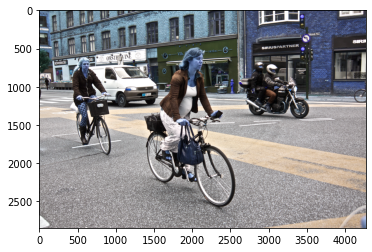

In [35]:
show_and_text('/content/1.jpg')

up in the background 


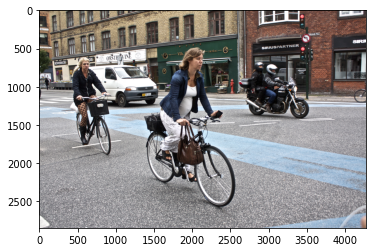

In [45]:
show_and_text('/content/1.jpg')

up to the camera . 


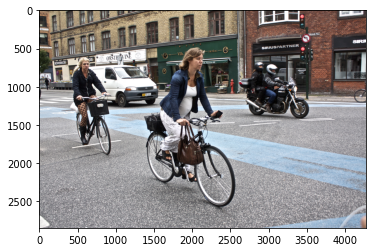

In [54]:
show_and_text('/content/1.jpg',False)

Я оставил только довольно наиболее логичные по картинке, смыслы. Но видно, что довольно забавное описание картинки.

**2 фотка**

in the park . 


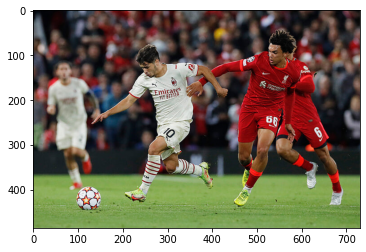

In [55]:
show_and_text('/content/2.jpg')

something to go . 


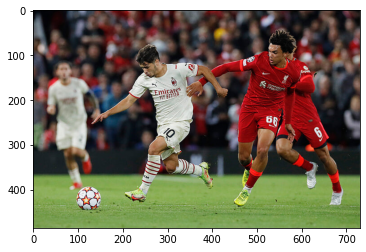

In [56]:
show_and_text('/content/2.jpg')

for his racquet . 


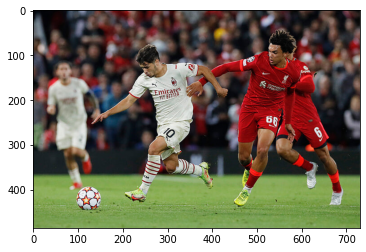

In [57]:
show_and_text('/content/2.jpg')

up to hit the shoreline . 


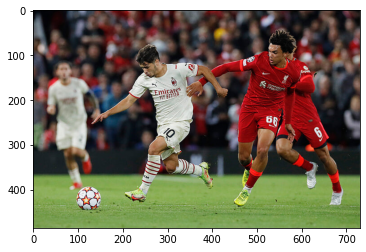

In [58]:
show_and_text('/content/2.jpg')

in the air . 


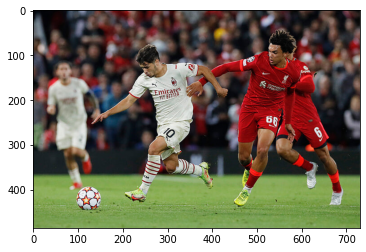

In [60]:
show_and_text('/content/2.jpg', False)

Хорошо видно, что тут более короткое, но и более точное описание. При это траву оно характеризовало, как парк, а футбол, как на свежем воздухе. Но при этом оно почему-то подумало, что это теннис (было про ракетку, типо спорт на траве)

**3 фотка**

at the airport 


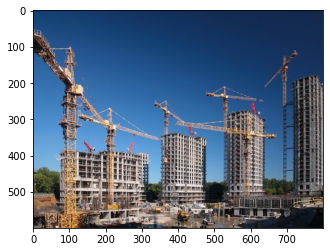

In [61]:
show_and_text('/content/3.jpg')

to get the building . 


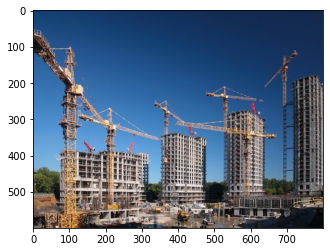

In [62]:
show_and_text('/content/3.jpg')

up from the sky . 


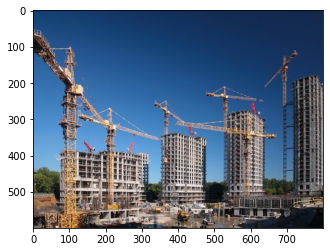

In [64]:
show_and_text('/content/3.jpg')

in the air . 


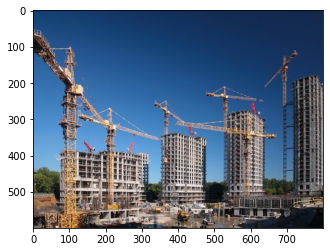

In [69]:
show_and_text('/content/3.jpg', False)

Тут снова довольно хорошо определяет, что тут на свежем вохдухе, так как небо. Также написало, что это небоскребы до самого неба, что это стройка, но спутало с аэропортом, например, мб так как небо и на фоне краны, которые она спутала

**4 фотка**

in the air . 


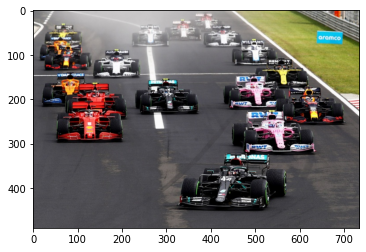

In [70]:
show_and_text('/content/4.jpg')

on a ground . 


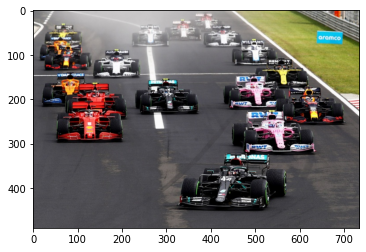

In [72]:
show_and_text('/content/4.jpg')

on a sunny day . 


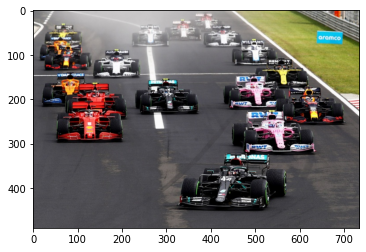

In [80]:
show_and_text('/content/4.jpg')

in the air . 


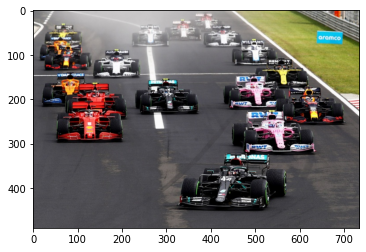

In [82]:
show_and_text('/content/4.jpg',False)

Снова определелило, что это на свежем воздухе и что это на дороге. А также, что это солнечный день, но почему-то ничего не сказало про автоспорт

**5 фотка**

for a picture . 


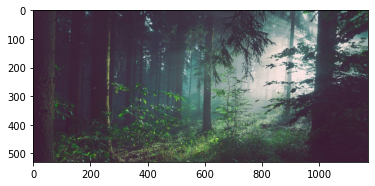

In [88]:
show_and_text('/content/5.jpg')

in the middle of a dark room . 


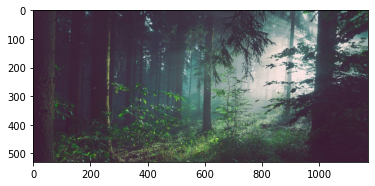

In [93]:
show_and_text('/content/5.jpg')

in a light . 


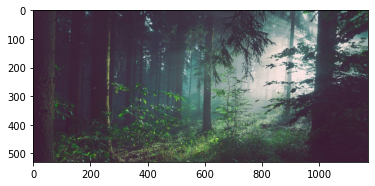

In [94]:
show_and_text('/content/5.jpg')

in the background . 


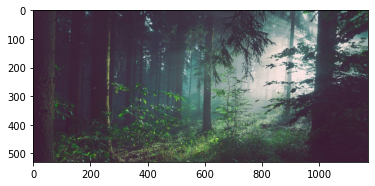

In [96]:
show_and_text('/content/5.jpg', False)

Вот тут особенно сложная фотография на самом деле. Так как оно говорит, что это задний фон, или в луче света, или "посреди темной комнаты", или что это картина. Отчасти каждый из этих вариантов правильный, но конечно мы юы хотели услышать природа, лес и т.д

**Вывод**:
На самом деле довольно хорошие результаты, сетка понимает, что происходит, но при этом она предлагает довольно разные варианты. Но мы ее недообучили до момента, когда начнется переобучение, так что мы просто не поработали с полным ее потенциалом, но видно, что она умеем хорошо различать предметы и понимать общую идею